## Heat Equation ##

We are going to solve the heat equation on a domain $\Omega_h$ with Dirichlet / Neumann boundary contitions.

The equation to solve is:

$$
\frac{\partial u}{\partial t} = \Delta u 
$$

Which we solve using,

$$
(u - u_n) = dt *  \Delta (\theta u + (1-\theta)u_n)
$$

As time integrator, here $u = u_{n+1}$. Since the eigenvalues of $\Delta$ are proportional to $\Delta x^2$, $\lambda = -c/\Delta x^2$, $c > 0$, we must be carefull with the stability region of the method. We have, for each eigenfunction, 

$$
(1 - \theta \lambda dt)u = (1 + (1-\theta) \lambda dt )u_n
$$

Thus, the amplification factor is: 

$$
|\frac{1 + (1-\theta)\lambda dt}{1 - \theta \lambda dt }| 
$$

and the system is unconditionaly stable if $\theta \geq 0.5$.



We shall use its weak form,

$$
\int [2 v*u +  \nabla v \cdot \nabla u ] \; d\Omega = \int [2*v*u_n - \nabla v \cdot \nabla u_n ] \; d\Omega
$$



In [1]:
import Pkg; Pkg.activate("gridap_makie")
using Gridap
using GridapMakie
using GLMakie; GLMakie.activate!() #WGLMakie
using FileIO
#using Plots
#mkdir("models")
#mkdir("images")
using GridapGmsh
using Gmsh
#using GridapGeosciences
using Gridap.Arrays
#using Gridap.TensorValues
using Gridap.ReferenceFEs
#using Gridap.Geometry
#using Gridap.Fields
using Gridap.Algebra
using SparseArrays
using Gridap.FESpaces
using Gridap.CellData

  Activating project at `~/Docencia/PDE/pde/2022/Numéricos/Tarea_7/gridap_makie`


In [72]:
include("../Tarea_6/models/mesh_generator.jl")
L = 1
displacement = 0.0
h = 10^(-1)

grid_type = "test"
p = (L*π,L*π, h) #for test (Length_x, Length_y, h) 
boundary_tags = ["ext"]
dirichlet_tags= ["ext"]
dirichlet_values = 0.0 # 0.0+im*0.0
model = make_model(grid_type, p)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000510213s, CPU 0.000442s)
Info    : Meshing 2D...
Info    : Meshing surface 100 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0463965s, CPU 0.039879s)
Info    : 1266 nodes 2534 elements
Info    : Writing 'models/rectangle.msh'...
Info    : Done writing 'models/rectangle.msh'
Info    : Reading 'models/rectangle.msh'...
Info    : 9 entities
Info    : 1266 nodes
Info    : 2530 elements
Info    : Done reading 'models/rectangle.msh'


UnstructuredDiscreteModel()

In [73]:
n = 60
domain = (0.0,1.0,0.0,1.0)
partition = (n,n)
model_h = CartesianDiscreteModel(domain,partition)


#T = 0.2           # final time for test
T = 0.8
num_steps = 2001   # number of time steps for 128 T=3 
#num_steps = 12000   # number of time steps for 128 T=6 
#num_steps = 10000   # number of time steps for 64 T=3 
#num_steps = 50000   # number of time steps for 64 T=6 
@show dt = T / (num_steps-1) # time step size


# Intervals where data is saved
n_int = 40 # for 64
#mod = 60 # for 128
#mod = 120 # for 128 T=6
#mod = 240 # for 256 T=3
#mod = 480

test_1 = false
test_2 = false
bump = false

#test_1 = true
test_2 = true # no funciona bien (Condiciones de Dirichlet no-homogéneas)
#bump = true

save_file = "Results/Heat/" #where to save things

println("dt / dx^2 = $(dt * n^2)   dt / dx = $(dt * n)  dt^3 / dx^6 = $((dt * n^2)^3)")

dt = T / (num_steps - 1) = 0.0004
dt / dx^2 = 1.4400000000000002   dt / dx = 0.024  dt^3 / dx^6 = 2.9859840000000006


The first number indicates what it would be the CFL condition for the explicit Euler method. The second a guide about taking time and space comparable steps. The third is proportinal to the error, obtained by expanding $\frac{1 + i\lambda dt /2}{1 - i\lambda dt /2} - e^{i\lambda dt}$

In [79]:
labels = get_face_labeling(model)
#add_tag_from_tags!(labels,"diri_all",[1,2,3,4,5,6,7,8]);


Gridap.Geometry.FaceLabeling:
 0-faces: 1266
 1-faces: 3667
 2-faces: 2402
 tags: 2
 entities: 108

In [74]:
order = 2
degree = order
Ωₕ = Triangulation(model)
dΩₕ = Measure(Ωₕ,degree)
#Ω₁ = Triangulation(model_1)

Measure()

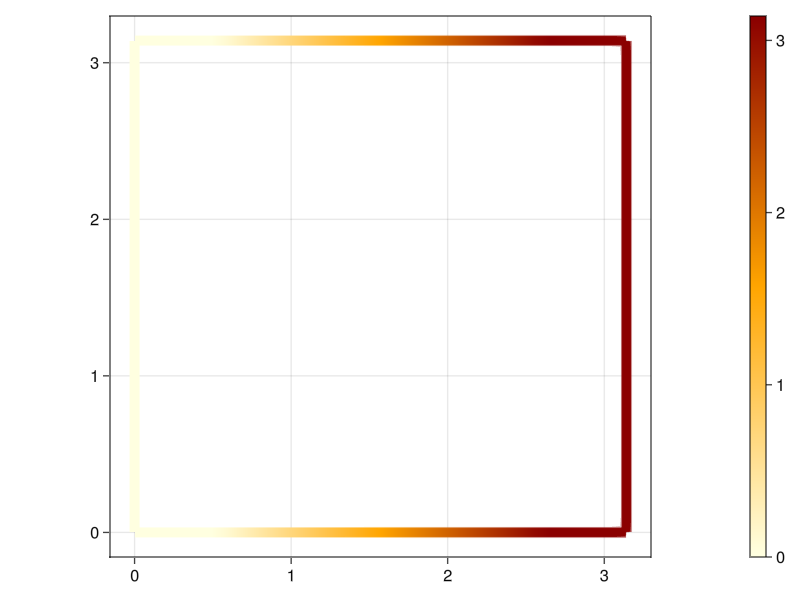

In [75]:
#plot(Γ₁)
ue(x) = x[1]
#Γ₁ = BoundaryTriangulation(model, tags="diri_all")
Γ₁ = BoundaryTriangulation(model, tags="ext")
fig, ax, plt = plot(Γ₁, ue, colormap=:heat, linewidth=10)
ax.aspect = AxisAspect(1)
Colorbar(fig[1, 2], plt)
fig
#display(fig)

In [42]:
#scatter(BoundaryTriangulation(model,tags=[4]))


We create the reference to the FE vector space.

In [76]:
reffe = ReferenceFE(lagrangian, Float64, order)

(Lagrangian(), (Float64, 2), Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}())

The test space has zero dirichlet data. 
The trial space can have a function as boundary value.

In [80]:
#V = TestFESpace(model,reffe,labels=labels,dirichlet_tags=["diri_all"],conformity=:H1)
V = TestFESpace(model,reffe,labels=labels,dirichlet_tags=["ext"],conformity=:H1)
if test_2 
    u_b(x)= x[1] + 2*x[2]
    U = TrialFESpace(V,u_b)
else
    U = TrialFESpace(V,0.0)
end

TrialFESpace()

In [81]:
#=
ls = LUSolver()
solver = LinearFESolver(ls)
=#

Next we set the initial data.

In [82]:
function u_0_bump(x,par) 
    r0, r1, p = par
    r = sqrt((x[1]-0.5)^2 + (x[2]-0.5)^2)
    if r >= r0 && r < r1
        return (r+r1)^p*(r-r1)^p / (((r1-r0))^(2p))
    else 
        return 0.0
    end
end

function u_0_test_1(x,p)
    n, m = p
    return sin(π*x[1]*n)*sin(π*x[2]*m)
end 

function u_0_test_2(x,p)
    return u_b(x) + u_0_test_1(x,p) # we superpose two solutions 
end
        
function test_solution(x,t,p)
    n, m = p
    ω = -π^2*(n^2+m^2)
    return u_0_test_1(x,p)*exp(ω*t) + (test_2)*u_b(x)
end

par_bump = (0.0, 0.25, 4)
par_test = (2, 3)

u_0_bump([0.5;0.5], par_bump)
#u_0_test([0.5;0.5], par_test)    
#u_0_particle([0.5;0.5], par_particle)


1.0

In [83]:
if test_1
    u_0(x) = u_0_test_1(x,par_test)
    save_file = save_file * "test_1"
elseif test_2
    u_0(x) = u_0_test_2(x,par_test)
    save_file = save_file * "test_2"
elseif bump
    save_file = save_file * "bump"
    u_0(x) = u_0_bump(x, par_bump)  
end

u_n = interpolate_everywhere(u_0,U)

#plot(Ωₕ, u_n)

SingleFieldFEFunction():
 num_cells: 2402
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 18285714505210066539

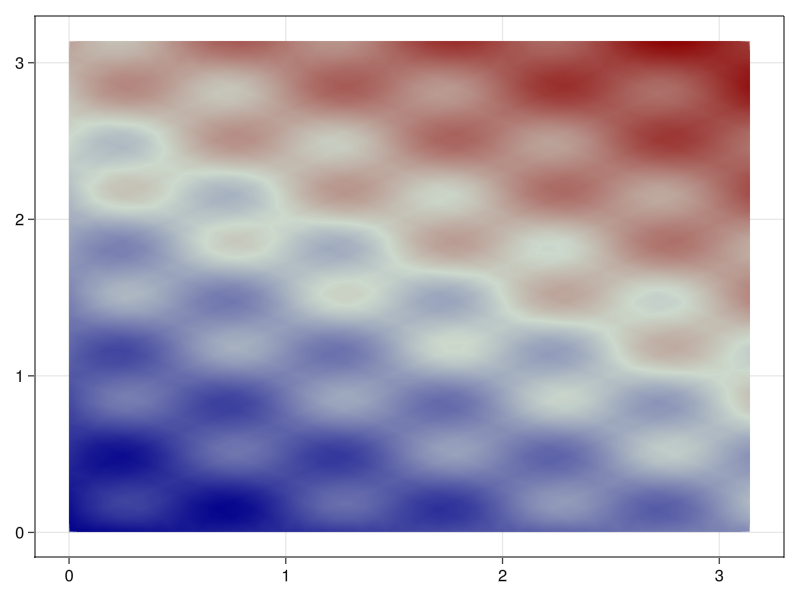

In [86]:
fig, ax, plt = plot(Ωₕ,u_0)
#fig, ax, plt = plot(Ω₁,ue)
#ax.aspect = AxisAspect(1)
#Colorbar(fig[2,1], plt, vertical=false)
fig
#display(fig)

To generate just once the matrix A we follow this example: https://github.com/gridap/Gridap.jl/blob/master/test/FESpacesTests/AssemblersTests.jl



In [ ]:
norm_L2(u) = sqrt(real(sum(∫(u' * u) * dΩₕ)))

In [ ]:
assem = SparseMatrixAssembler(U,V)
dv = get_fe_basis(V)
du = get_trial_fe_basis(U)

a(u,v) = ∫(∇(v) ⋅ ∇(u)*dt + 2*v*u)dΩₕ

mat_contribs = a(du,dv)
data = collect_cell_matrix(U,V,mat_contribs)
A = assemble_matrix(assem,data)

In [ ]:
t = 0
u_n = interpolate_everywhere(u_0,U)
writevtk(
          Ωₕ,save_file * "_$(lpad(0,3,'0'))",
          cellfields=["T"=>u_n])

if test_1 || test_2 
    e = zeros(num_steps ÷ n_int)
end
    
for istep in 1:num_steps

    if (istep-1) % n_int == 0 && istep > 1
        writevtk(
          Ωₕ, save_file * "_$(lpad(istep,3,'0'))",
          cellfields=["T"=>u_n])
        if test_1 || test_2
            u_0(x) = test_solution(x,t,par_test)
            u_s = interpolate_everywhere(u_0,U)
            error = norm_L2(u_n - u_s)
            e[(istep-1) ÷ n_int] = error
            l2 = norm_L2(u_n)
            println("time = $t, error = $(error), l2 = $(l2)")
            #println("")
        else
        println("Solving in step $istep of $num_steps")
        end
    end
    
    b(v) = ∫(∇(v) ⋅ ∇(-u_n)*dt + 2*v*u_n)dΩₕ
    vec_contribs = b(dv)
    data = collect_cell_vector(V,vec_contribs)
    bv = assemble_vector(assem,data)
    
    #op = AffineFEOperator(a,b,U,V)
    #uh = solve(solver,op)
    x = A \ bv
    t = t+dt
    uh = FEFunction(U,x)
    u_n = uh
    
    
        

end

Vemos que para el `test_1` el error tiene un crecimiento lineal, tal como se espera. Mientras que para el `test_2` se ve que rápidamente satura con un error grande. En el gráfico se ve que llega a una solución interna distinta a la de los datos de contorno.

In [ ]:
if test_1 || test_2
    scatter(e)
end